In [22]:
from model_instantiation import *
from model_training import *
from dataset_partitioning import *
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
from scipy.stats import gaussian_kde

In [2]:
forum = 'overflow'
collection = get_mongo_collection(forum)

In [8]:
classifier_hyperparameters = {'output_dir': '../data/overflow/BERT',
                              'num_train_epochs': 1,
                              'disable_tqdm': False,
                              'batch_size': 32,
                              'head': 'classification',
                             'learning_rate': 3e-4}

In [49]:
classifier_train = get_classifier_dataset_partition(collection, 'classification_train')
classifier_val = get_classifier_dataset_partition(collection, 'classification_val')
model, collate_fn = get_bert_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [50]:
trainer = Trainer(model=model,
                      args=get_train_args(**classifier_hyperparameters),
                      data_collator=collate_fn,
                      train_dataset=classifier_train,
                      eval_dataset=classifier_val)

In [51]:
def freeze_model(model):
    """Freeze all layers except the final classification layer."""
    for p in model.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = True
    for p in model.bert.pooler.parameters():
        p.requires_grad = True
freeze_model(model)

In [52]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=8693, training_loss=0.4591861076710428, metrics={'train_runtime': 235.8685, 'train_samples_per_second': 36.855, 'total_flos': 5665651503355728, 'epoch': 1.0})

In [53]:
results = trainer.predict(trainer.eval_dataset)

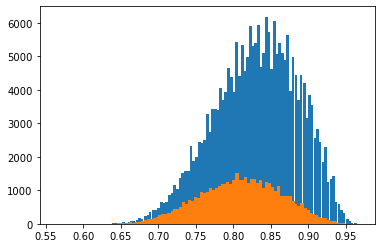

In [54]:
bins = 100
#probs = result.predictions[:,1]
probs = softmax(results.predictions, axis=1)[:,1]
labels = results.label_ids
#plt.hist(probs, bins=bins);
plt.hist(probs[labels==1], bins=bins);
plt.hist(probs[labels==0], bins=bins);

In [55]:
roc_auc_score(labels, probs)

0.6120883615703183

Text(0.5, 1.0, 'Validation for BERT classifier')

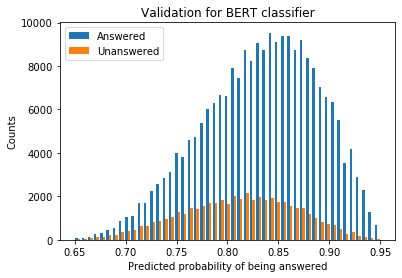

In [40]:
probs0 = probs[labels==0]
probs1 = probs[labels==1]
num_bins = 50
p = np.linspace(0.65, 0.95, num_bins)
(counts1,counts0),_,_ = plt.hist((probs1,probs0),bins=p)
plt.legend(['Answered','Unanswered'])
plt.ylabel('Counts')
plt.xlabel('Predicted probability of being answered')
plt.title('Validation for BERT classifier')

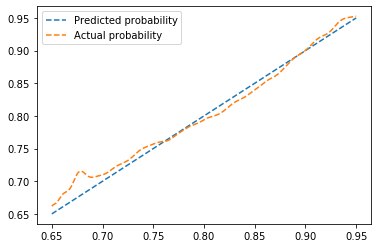

In [56]:
bw = 0.1
factor = len(probs0)/len(probs1)
kde0 = gaussian_kde(probs0,bw)
kde1 = gaussian_kde(probs1,bw)
p_up = np.linspace(0.65,0.95,1000)
plt.plot(p_up,p_up,linestyle='dashed')
plt.plot(p_up,1/(factor*kde0(p_up)/kde1(p_up)+1),linestyle='dashed')
plt.legend(['Predicted probability','Actual probability'])
#plt.xlabel('Probability')

In [57]:
def unfreeze_model(model):
    """Unfreeze all layers."""
    for p in model.parameters():
        p.requires_grad = True
unfreeze_model(model)

In [65]:
classifier_hyperparameters['learning_rate'] = 3e-5
trainer = Trainer(model=model,
                      args=get_train_args(**classifier_hyperparameters),
                      data_collator=collate_fn,
                      train_dataset=classifier_train,
                      eval_dataset=classifier_val)
trainer.train()

Step,Training Loss


TrainOutput(global_step=8693, training_loss=0.40055337605508745, metrics={'train_runtime': 768.9175, 'train_samples_per_second': 11.306, 'total_flos': 5665651503355728, 'epoch': 1.0})

In [66]:
results = trainer.predict(trainer.eval_dataset)

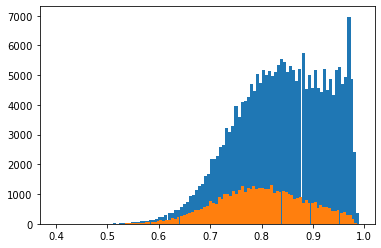

In [67]:
bins = 100
#probs = result.predictions[:,1]
probs = softmax(results.predictions, axis=1)[:,1]
labels = results.label_ids
#plt.hist(probs, bins=bins);
plt.hist(probs[labels==1], bins=bins);
plt.hist(probs[labels==0], bins=bins);

In [68]:
roc_auc_score(labels, probs)

0.6375924661609539

Text(0.5, 1.0, 'Validation for BERT classifier')

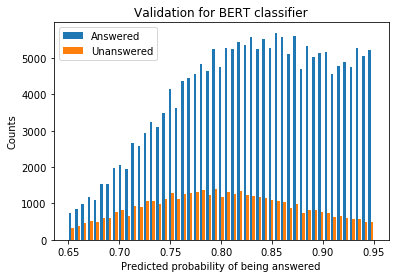

In [69]:
probs0 = probs[labels==0]
probs1 = probs[labels==1]
num_bins = 50
p = np.linspace(0.65, 0.95, num_bins)
(counts1,counts0),_,_ = plt.hist((probs1,probs0),bins=p)
plt.legend(['Answered','Unanswered'])
plt.ylabel('Counts')
plt.xlabel('Predicted probability of being answered')
plt.title('Validation for BERT classifier')

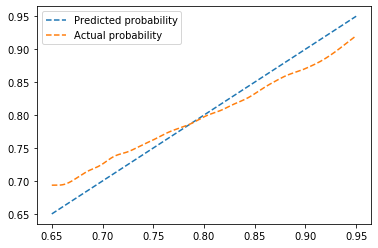

In [70]:
bw = 0.1
factor = len(probs0)/len(probs1)
kde0 = gaussian_kde(probs0,bw)
kde1 = gaussian_kde(probs1,bw)
p_up = np.linspace(0.65,0.95,1000)
plt.plot(p_up,p_up,linestyle='dashed')
plt.plot(p_up,1/(factor*kde0(p_up)/kde1(p_up)+1),linestyle='dashed')
plt.legend(['Predicted probability','Actual probability'])
#plt.xlabel('Probability')

In [64]:
trainer.save_model()

In [72]:
classifier_train.results

[{'Title': 'Document Classification with scikit-learn: most efficient way to get the words (token) that impacted more on the classification',
  'Answered': True},
 {'Title': 'Finding all descendandts in tree', 'Answered': True},
 {'Title': 'Find Indexes of a List of DataFrame that have NaN Values - Pandas',
  'Answered': True},
 {'Title': 'How to access Object within JSON?', 'Answered': True},
 {'Title': 'Eclipse CDT white bar removal', 'Answered': False},
 {'Title': 'select all data of two different table using case',
  'Answered': True},
 {'Title': 'Validation reactive form with formarray', 'Answered': True},
 {'Title': 'Telebot package problem with importing "Types"',
  'Answered': False},
 {'Title': 'Unwanted gaps around transparent elements', 'Answered': False},
 {'Title': 'How to speed up R packages installation in docker',
  'Answered': True},
 {'Title': 'Print Matrix in python with specific formatting',
  'Answered': True},
 {'Title': 'Whats the best way to use google credentia

In [73]:
trainer = Trainer(model=model,
                      args=get_train_args(**classifier_hyperparameters),
                      data_collator=collate_fn,
                      train_dataset=classifier_train.results,
                      eval_dataset=classifier_val.results)

In [74]:
trainer.evaluate()

KeyboardInterrupt: 